In [43]:
# Import python packages
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
#import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Load imputed Houston data
df_houston = pd.read_pickle("houston_df.pkl")




In [44]:
print(df_houston)

df_houston_raw = df_houston.copy()

                  cuisine product_type     revenue        cost    cases  \
0                   Asian     Non Food    64848.40    40577.02   1700.0   
1                   Asian     Non Food    67882.92    45765.28   1706.0   
2                   Asian     Non Food    67106.98    46050.63   1707.0   
3                   Asian     Non Food    79953.54    46981.28   1830.0   
4                   Asian     Non Food    65375.47    42107.22   1841.0   
...                   ...          ...         ...         ...      ...   
1515  Mainstream American     Proteins  1239347.31  1108906.52  12105.0   
1516  Mainstream American     Proteins  1232865.06  1096102.99  11995.0   
1517  Mainstream American     Proteins  1410584.59  1255203.38  13602.0   
1518  Mainstream American     Proteins  1372757.72  1104560.71  12246.0   
1519  Mainstream American     Proteins  1263746.98  1017769.43  12580.0   

      customer_count     city       week  
0              135.0  HOUSTON 2020-06-29  
1            

In [45]:
# Instantiate a linear model
linear_model=LinearRegression()

# Generate a uniform x variable representing the time steps
x=np.array(range(len(df_houston))).reshape(-1, 1)

# Fit the model
fit_result=linear_model.fit(x, df_houston['revenue'])

# Make predictions over the input domain
predictions=linear_model.predict(x)

# Add the linear model predictions back to the dataframe
df_houston['Linear model']=predictions

# calculate the root mean squared error
rmse=sqrt(mean_squared_error(df_houston['revenue'], predictions))

# Save the result for later
rmse_results={'Linear model': rmse}

# Display the result for the user
print(f'Root mean square error: {rmse:.1f}')

Root mean square error: 380379.4


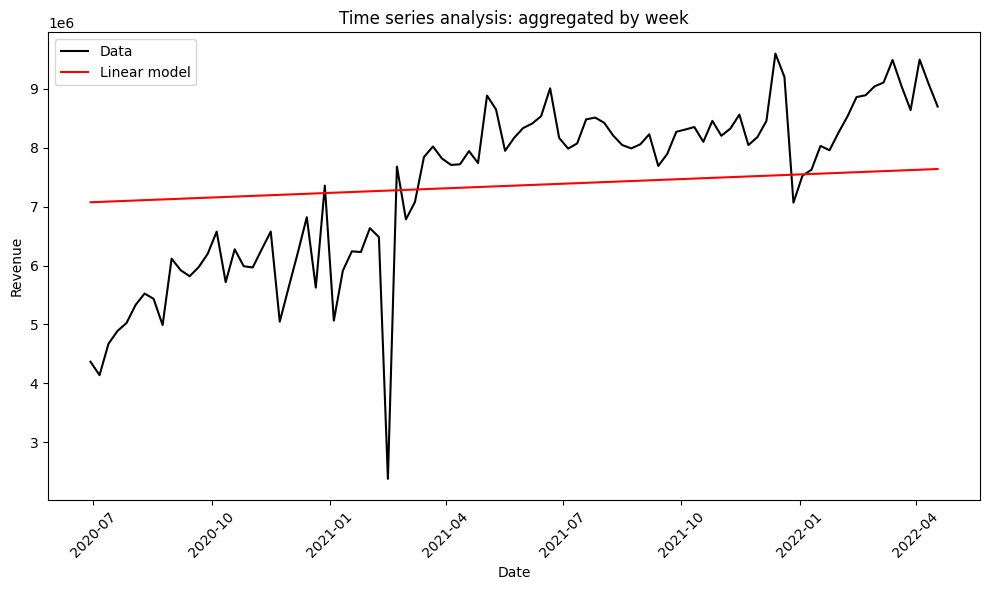

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Ensure 'week' is datetime
df_houston['week'] = pd.to_datetime(df_houston['week'])

# Step 2: Aggregate revenue and linear model by week
df_weekly = df_houston.groupby('week', as_index=False)[['revenue', 'Linear model']].sum()

# Step 3: Plot
plt.figure(figsize=(10, 6))
plt.plot(df_weekly['week'], df_weekly['revenue'], label='Data', color='black')
plt.plot(df_weekly['week'], df_weekly['Linear model'], label='Linear model', color='red')

plt.title('Time series analysis: aggregated by week')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
weekly_revenue = df_houston.groupby('week')['revenue'].sum().asfreq('W-MON')

In [48]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(df_houston['revenue'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.028


Stationary Dataset

In [49]:
#timeseries_model=auto_arima(df_houston['revenue'], seasonal=True, stationary=False, trace=True, m=12)

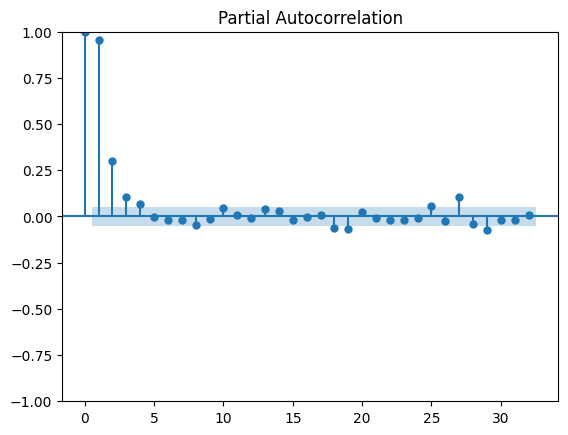

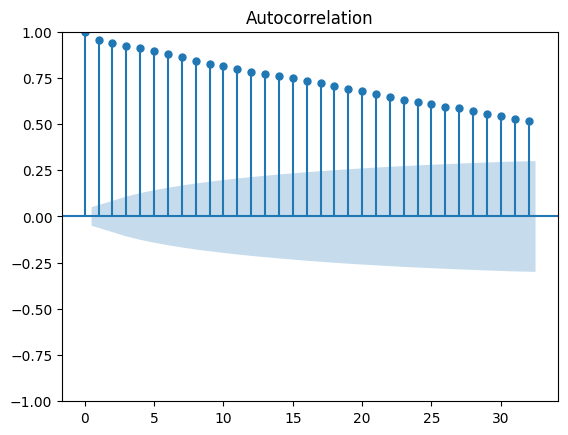

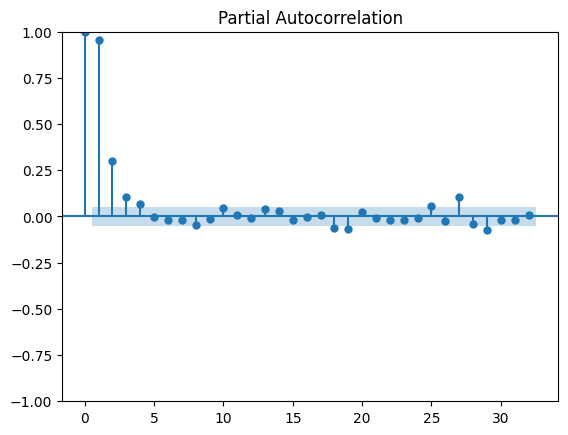

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_houston['revenue'])
plot_pacf(df_houston['revenue'])

In [51]:
df_houston['log_revenue'] = np.log(df_houston['revenue'])


In [52]:
import statsmodels.api as sm

order = (0, 1, 1)
seasonal_order = (0, 1, 1, 12)

model = sm.tsa.SARIMAX(df_houston['log_revenue'], order=order, seasonal_order=seasonal_order).fit()

print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        log_revenue   No. Observations:                 1520
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -497.063
Date:                            Sun, 15 Jun 2025   AIC                           1000.125
Time:                                    16:36:49   BIC                           1016.079
Sample:                                         0   HQIC                          1006.067
                                           - 1520                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3880      0.009    -45.241      0.000      -0.405      -0.371
ma.S.L12      -0.9999      4.482   

The model captures trend and seasonality (d=1, D=1, s=12), but only the short-term MA(1) is significant.

Residuals are non-normal and heteroskedastic, which may hurt forecasting performance

Let's start the modeling now

Note- I wanted to use AutoArima here but had severe compatability issues with pmdarima so had to use ARIMA with statsmodels instead and do a bit more manual tuning. 

In [53]:
weekly_revenue_diff = weekly_revenue.diff().dropna()

In [54]:
# Fit model on differenced data
model = ARIMA(weekly_revenue_diff, order=(1, 1, 1))  
fitted = model.fit()

# Forecast differenced values
forecast_diff = fitted.forecast(steps=12)

# Recover original forecasted revenue values by cumulatively summing 
# and adding the last known actual value before differencing
last_actual = df_houston['revenue'].iloc[-1]
forecast_revenue = forecast_diff.cumsum() + last_actual

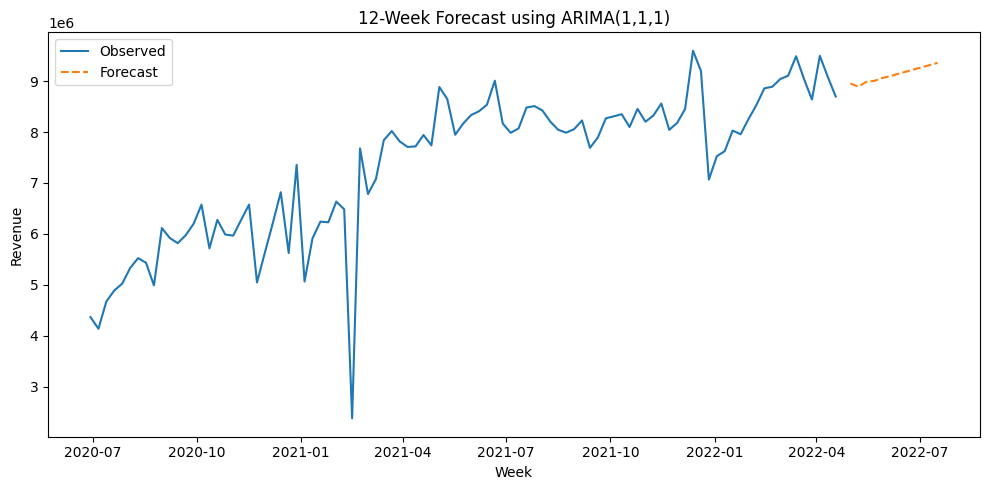

In [55]:


# Reintegrate (undo differencing)
last_observed = weekly_revenue.iloc[-1]
forecast = forecast_diff.cumsum() + last_observed

# Plot
plt.figure(figsize=(10, 5))
plt.plot(weekly_revenue.index, weekly_revenue, label='Observed')
plt.plot(pd.date_range(weekly_revenue.index[-1], periods=13, freq='W')[1:], forecast, label='Forecast', linestyle='--')
plt.title("12-Week Forecast using ARIMA(1,1,1)")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
for p in range(0, 4):
    for d in range(1, 2):
        for q in range(0, 4):
            try:
                model = ARIMA(df['revenue'], order=(p, d, q))
                results = model.fit()
                print(f'ARIMA({p},{d},{q}) AIC: {results.aic}')
            except:
                continue

In [57]:
ts = df_houston['revenue']  # or weekly_revenue, etc.

In [58]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

best_aic = float("inf")
best_order = None
best_model = None

for p in range(0, 4):
    for d in range(1, 3):  
        for q in range(0, 4):
            try:
                model = ARIMA(ts, order=(p, d, q))
                result = model.fit()
                aic = result.aic
                print(f'ARIMA({p},{d},{q}) AIC: {aic:.2f}')
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = result
            except:
                continue

print(f'\n✅ Best ARIMA order: {best_order} with AIC: {best_aic:.2f}')

ARIMA(0,1,0) AIC: 39855.08
ARIMA(0,1,1) AIC: 39648.77
ARIMA(0,1,2) AIC: 39650.62
ARIMA(0,1,3) AIC: 39652.63
ARIMA(0,2,0) AIC: 41314.76
ARIMA(0,2,1) AIC: 39871.03
ARIMA(0,2,2) AIC: 39666.64
ARIMA(0,2,3) AIC: 39649.53
ARIMA(1,1,0) AIC: 39681.76
ARIMA(1,1,1) AIC: 39650.61
ARIMA(1,1,2) AIC: 39652.63
ARIMA(1,1,3) AIC: 39653.79
ARIMA(1,2,0) AIC: 40575.10
ARIMA(1,2,1) AIC: 39721.06
ARIMA(1,2,2) AIC: 39655.95
ARIMA(1,2,3) AIC: 39649.08
ARIMA(2,1,0) AIC: 39658.04
ARIMA(2,1,1) AIC: 39652.58
ARIMA(2,1,2) AIC: 39654.58
ARIMA(2,1,3) AIC: 39656.73
ARIMA(2,2,0) AIC: 40280.36
ARIMA(2,2,1) AIC: 39703.98
ARIMA(2,2,2) AIC: 39652.63
ARIMA(2,2,3) AIC: 39650.46
ARIMA(3,1,0) AIC: 39650.85
ARIMA(3,1,1) AIC: 39652.77
ARIMA(3,1,2) AIC: 39651.64
ARIMA(3,1,3) AIC: 39652.06
ARIMA(3,2,0) AIC: 40089.10
ARIMA(3,2,1) AIC: 39699.33
ARIMA(3,2,2) AIC: 39651.93
ARIMA(3,2,3) AIC: 39646.25

✅ Best ARIMA order: (3, 2, 3) with AIC: 39646.25


In [59]:
best_order = (3, 2, 3)

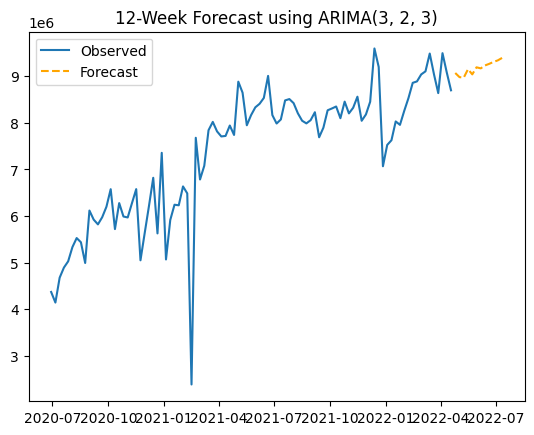

In [60]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

model = ARIMA(weekly_revenue, order=best_order)
fitted = model.fit()

forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using ARIMA{best_order}")
plt.legend()
plt.show()

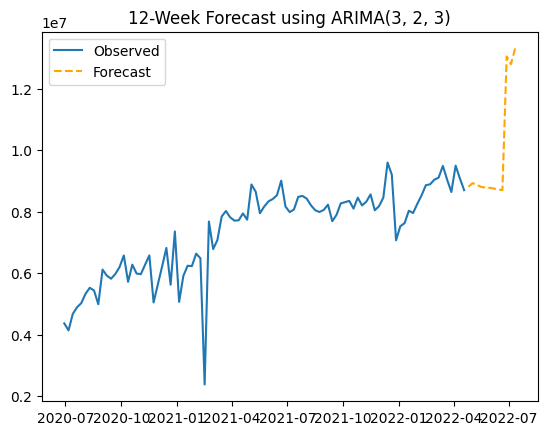

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(weekly_revenue, order=(3, 2, 3), seasonal_order=(1, 1, 1, 52))
fitted = model.fit()
forecast = fitted.forecast(steps=12)

plt.plot(weekly_revenue, label='Observed')  # <- corrected here
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title(f"12-Week Forecast using ARIMA{best_order}")
plt.legend()
plt.show()

Going to get ACF plot to help determine best s value

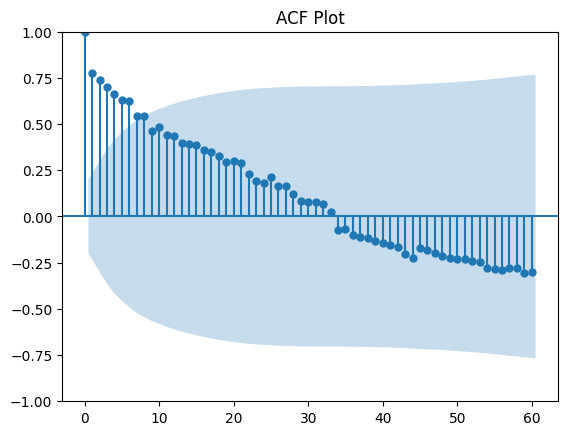

In [62]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(weekly_revenue, lags=60)
plt.title("ACF Plot")
plt.show()

Was not very helpful- will try some values out

In [63]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

seasonal_candidates = [1, 4, 13, 26, 52]
aic_scores = []

for s in seasonal_candidates:
    try:
        model = SARIMAX(weekly_revenue, order=(1, 1, 1), seasonal_order=(1, 1, 1, s))
        fit = model.fit(disp=False)
        aic_scores.append((s, fit.aic))
    except:
        continue

aic_scores.sort(key=lambda x: x[1])
print("Best seasonal period by AIC:", aic_scores[0])

Best seasonal period by AIC: (52, np.float64(1261.5391872660443))


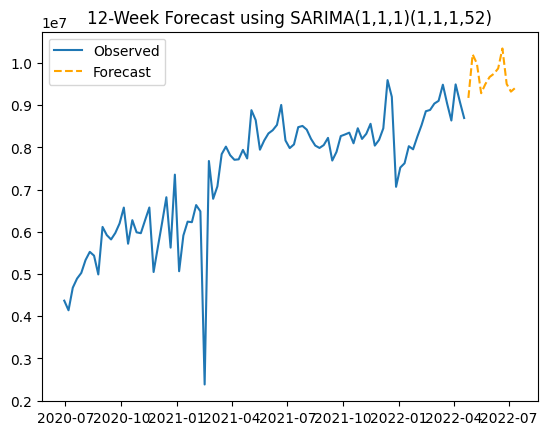

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(1, 1, 1),                
    seasonal_order=(1, 1, 1, 52),   
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMA(1,1,1)(1,1,1,52)")
plt.legend()
plt.show()

In [65]:
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], 1, x[2], 52) for x in pdq]

lowest_aic = float("inf")
best_config = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                weekly_revenue,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < lowest_aic:
                lowest_aic = results.aic
                best_config = (param, param_seasonal)
        except:
            continue

print("Best SARIMA config:", best_config)
print("Lowest AIC:", lowest_aic)

Best SARIMA config: ((0, 1, 0), (0, 1, 1, 52))
Lowest AIC: 4.0


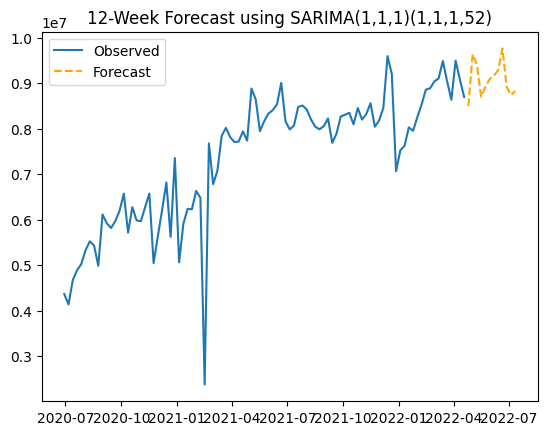

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    weekly_revenue,
    order=(0, 1, 0),                # Simpler ARIMA
    seasonal_order=(0, 1, 1, 52),   # Annual seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
forecast = results.forecast(steps=12)

# Plot
plt.plot(weekly_revenue, label="Observed")
plt.plot(forecast.index, forecast, '--', label='Forecast', color='orange')
plt.title("12-Week Forecast using SARIMA(1,1,1)(1,1,1,52)")
plt.legend()
plt.show()

In [67]:
forecast = results.get_forecast(steps=12)
forecast_values = forecast.predicted_mean

print("12-Week Forecast Values:")
print(forecast_values)

12-Week Forecast Values:
2022-04-25    8494975.67
2022-05-02    9639180.18
2022-05-09    9403030.06
2022-05-16    8702677.49
2022-05-23    8920697.82
2022-05-30    9088224.16
2022-06-06    9163763.42
2022-06-13    9289669.32
2022-06-20    9762853.27
2022-06-27    8921776.24
2022-07-04    8740114.06
2022-07-11    8827540.45
Freq: W-MON, Name: predicted_mean, dtype: float64


In [68]:

forecast_df = forecast.predicted_mean.to_frame(name="forecast")

forecast_df.to_pickle("forecast_12_weeks.pkl")
forecast_df.to_csv("forecast_12_weeks.csv")


In [69]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon= 12

# Set a model order, i.e. how many past data points should be used as input for prediction
model_order=100

In [70]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(df_houston) - testing_dataset_size

# Get the training and testing sets
training_data=df_houston[:training_set_size]
testing_data=df_houston[training_set_size:]

In [71]:
# Ensure 'week' is datetime
df_houston['week'] = pd.to_datetime(df_houston['week'])

# Group by week + city, sum revenue and other relevant columns
df_houston_agg = df_houston.groupby(['week', 'city'], as_index=False).agg({
    'revenue': 'sum',
    'cost': 'sum',
    'cases': 'sum',
    'customer_count': 'sum'
})

# Optional: Just filter for one city (if modeling per-city)
df_houston_city = df_houston_agg[df_houston_agg['city'] == 'HOUSTON'].copy()

# Set week as index and sort
df_houston_city = df_houston_city.sort_values('week')
df_houston_city.set_index('week', inplace=True)

# Add log transform
df_houston_city['log_revenue'] = np.log(df_houston_city['revenue'])

Datetime index type: <class 'pandas.core.indexes.base.Index'>
First few rows:   cuisine product_type   revenue      cost   cases  customer_count     city  \
0   Asian     Non Food  64848.40  40577.02  1700.0           135.0  HOUSTON   
1   Asian     Non Food  67882.92  45765.28  1706.0           152.0  HOUSTON   
2   Asian     Non Food  67106.98  46050.63  1707.0           142.0  HOUSTON   
3   Asian     Non Food  79953.54  46981.28  1830.0           155.0  HOUSTON   
4   Asian     Non Food  65375.47  42107.22  1841.0           147.0  HOUSTON   

        week   Linear model  log_revenue  
0 2020-06-29  174868.198526    11.079808  
1 2020-07-06  175243.230694    11.125540  
2 2020-07-13  175618.262862    11.114043  
3 2020-07-20  175993.295030    11.289201  
4 2020-07-27  176368.327198    11.087902  


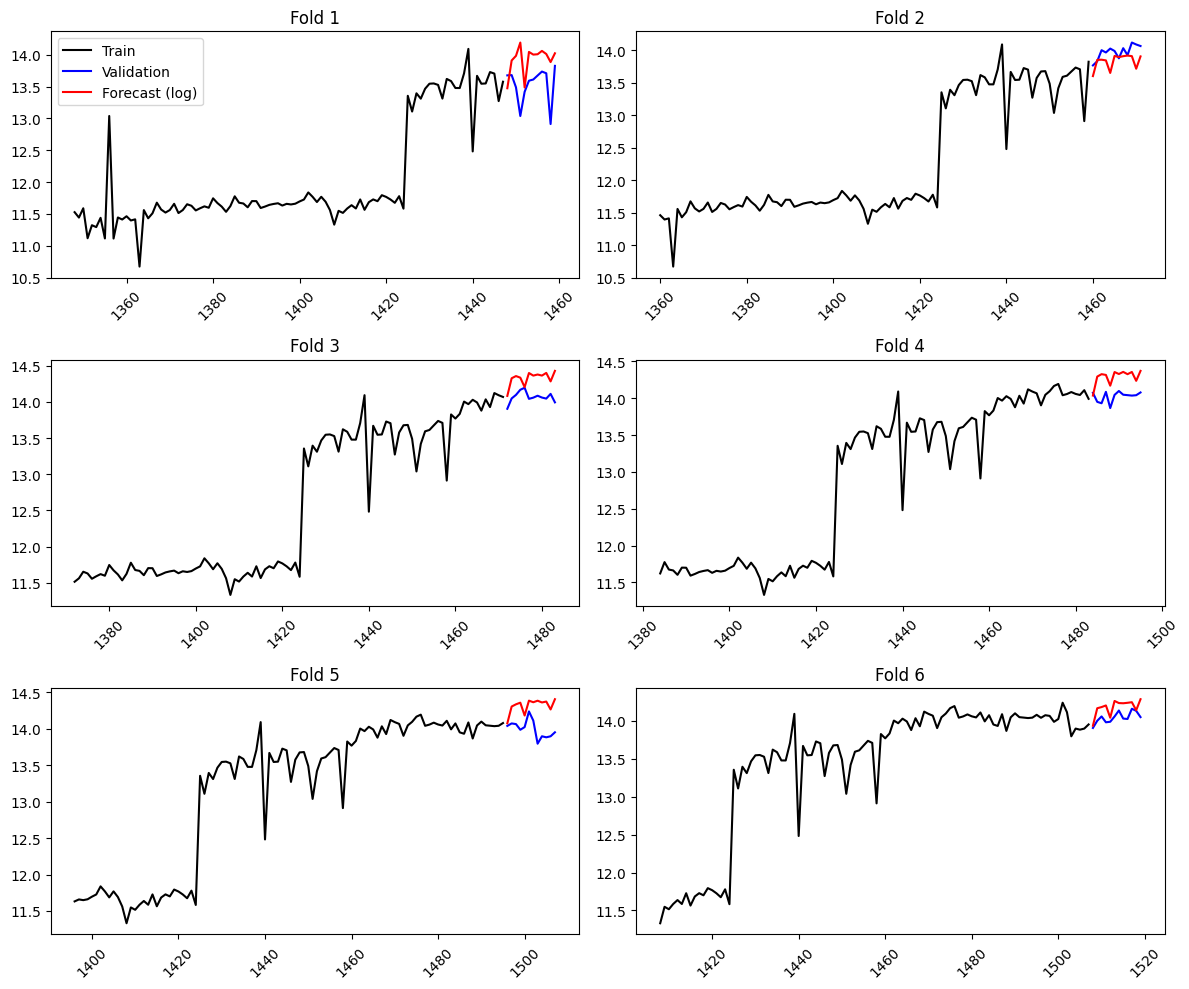


Average RMSE across folds (original revenue scale): 367,227.00


In [81]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Just sort by the index since 'week' is already set as index
df_houston = df_houston.sort_index()

# Optional sanity check
print("Datetime index type:", type(df_houston.index))
print("First few rows:", df_houston.head())

# Parameters
folds = 6
forecast_horizon = 12
model_order = 100  # min training size for SARIMA to stabilize

# Holders
validation_rmse_values = []
predicted_values = []
validation_values = []

# Set up plots
fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Cross-validation loop
for i, (train_idx, val_idx) in enumerate(tscv.split(df_houston)):

    train = df_houston.iloc[train_idx]
    val = df_houston.iloc[val_idx]

    # Fit model
    model = SARIMAX(train['log_revenue'], order=(0, 1, 1), seasonal_order=(0, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.forecast(steps=len(val))

    # Back-transform
    forecast_exp = np.exp(forecast)
    actual_exp = np.exp(val['log_revenue'])

    # Save for global RMSE later
    predicted_values.extend(forecast_exp)
    validation_values.extend(actual_exp)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(actual_exp, forecast_exp))
    validation_rmse_values.append(rmse)

    # Plot
    axs[i].plot(train.index, train['log_revenue'], label='Train', color='black')
    axs[i].plot(val.index, val['log_revenue'], label='Validation', color='blue')
    axs[i].plot(val.index, forecast, label='Forecast (log)', color='red')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].tick_params(axis='x', labelrotation=45)

    if i == 0:
        axs[i].legend()

plt.tight_layout()
plt.show()

# Final RMSE summary
if validation_rmse_values:
    print(f"\nAverage RMSE across folds (original revenue scale): {np.mean(validation_rmse_values):,.2f}")
else:
    print("\nNo valid RMSE values calculated.")